In [85]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import xarray as xr
import pandas as pd
from tqdm import tqdm
import warnings
import cartopy.crs as ccrs
from scipy.stats import iqr

from matplotlib import rc 
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
# plt.rcdefaults()

import sys 
sys.path.append("../scripts")
import InfoTheoryMetrics
from InfoTheoryMetrics import freedman_diaconis_bins

# Calculate the information theory metrics on correlated Gaussian arrays

In [71]:
N=100 # Number of ensemble members
m=10000 # Number of data points in each member

corr_coeffs = np.linspace(0,1,100)
rho_m_1 = np.zeros(len(corr_coeffs)) # signal-to-noise ratio
rho_m_2 = np.zeros(len(corr_coeffs)) # leave-one-out correlation 
I_sf = np.zeros(len(corr_coeffs))
H_f = np.zeros(len(corr_coeffs))
lam = np.zeros(len(corr_coeffs)) # mutual information 2

In [81]:
N = 500
MU = np.zeros(N)
for k in tqdm(range(len(corr_coeffs))):
    # Generate the idealized Gaussian arrays
    SIGMA = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if not i==j:
                SIGMA[i,j] = corr_coeffs[k]
            else:
                SIGMA[i,j] = 1
    f = np.random.multivariate_normal(MU, SIGMA, size=m).T # turn Gaussian arrays into ensemble model output
    s = np.mean(f, axis=0) # "signal" 

    # ===================== INFORMATION METRIC CALCULATION ========================
    # Flatten f and g for entropy calculation
    s_bin = freedman_diaconis_bins(np.tile(s,N))
    f_bin = freedman_diaconis_bins(f.flatten())
    I_sf[k], _, H_f[k] = InfoTheoryMetrics.I_jugaad(s, f, nbins_alt=(s_bin, f_bin))
    
    # ===================== VARIANCE METRIC CALCULATION ========================
    V_s = np.var(s)
    eta = s - f
    total_var = np.mean(np.var(f, axis=1), axis=0)
    rho_m_1[k] = np.sqrt(V_s/total_var)
    
    # ===================== VARIANCE METRIC 2 (LEAVE-ONE-OUT) CALCULATION ========================
    # For large enough ensembles, this metric is equivalent to the one above
#     for i in range(N):
#         LOO_g_t = f[i]
#         rest_of_f = [x for x in np.arange(N) if x!=i]
#         rest_of_f = f[rest_of_f]
#         LOO_s_t = rest_of_f.mean(axis=0)
#         rho_m_2[k] += np.corrcoef(LOO_g_t, LOO_s_t)[0,1] / N

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.58s/it]


In [82]:
gam_m = I_sf / H_f
lam = np.sqrt(1 - np.power(2, -2*I_sf))

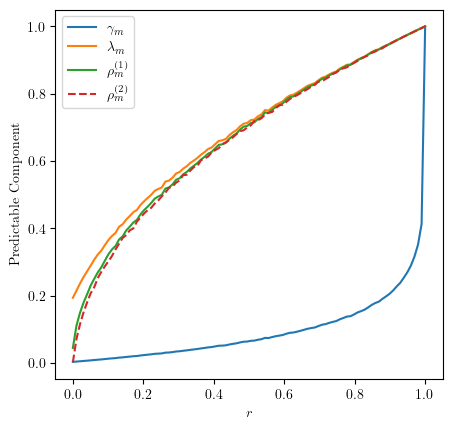

In [87]:
# Plot the metrics against the correlation
fig = plt.figure()
plt.plot(corr_coeffs, gam_m, label="$\gamma_m$")
plt.plot(corr_coeffs, lam, label="$\lambda_m$")
plt.plot(corr_coeffs, rho_m_1, label="$\\rho_{m}^{(1)}$")
plt.plot(corr_coeffs, rho_m_2, '--', label="$\\rho_{m}^{(2)}$")
plt.legend()
plt.xlabel("$r$")
plt.ylabel("Predictable Component")
fig.set_figwidth(5)

In [98]:
# Test the MI estimation against the analytic formula on Gaussian arrays

N=2 # Number of ensemble members
m=15000 # Number of data points in each member

N_SAMPLES = 40

corr_coeffs = np.linspace(0,1,250)
I_sf_2 = np.zeros((N_SAMPLES, len(corr_coeffs)))

MU = np.zeros(N)
for k in tqdm(range(len(corr_coeffs))):
    # Generate the idealized Gaussian arrays
    SIGMA = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if not i==j:
                SIGMA[i,j] = corr_coeffs[k]
            else:
                SIGMA[i,j] = 1
    
    for sample in range(N_SAMPLES):
        f = np.random.multivariate_normal(MU, SIGMA, size=m).T # ensemble model output
        s = np.mean(f, axis=0) # "signal" 
        
        bin_1 = freedman_diaconis_bins(f[0])
        bin_2 = freedman_diaconis_bins(f[1])
        I_sf_2[sample, k], _, _ = InfoTheoryMetrics.I(f[0], f[1], nbins_alt=(bin_1, bin_2))

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:39<00:00,  6.28it/s]


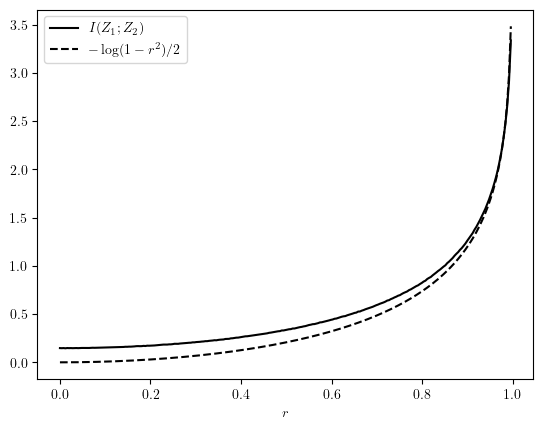

In [105]:
plt.plot(corr_coeffs[:-1], I_sf_2.mean(axis=0)[:-1], c='black', label='$I(Z_1;Z_2)$')
plt.plot(corr_coeffs[:-1], -np.log2(1 - corr_coeffs[:-1]**2)/2, '--', c='black', label='$-\log(1-r^2)/2$')
plt.xlabel("$r$")
plt.legend()